In [ ]:
include("../../spikenet/spikenet.jl")

In [2]:
using SpikeNet
using Parameters
using ProgressMeter
using Images
using Interact

Load the natural images dataset from Olshausen & Field:

In [3]:
include("../natimages.jl")
const images = nat_images()
const P = 16 # patch size

16

Build SAILnet:

In [4]:
include("sailnet.jl")

train_one (generic function with 3 methods)

In [56]:
Nx = 16
Ny = 16
N = Nx*Ny

input = InputBuffer(zeros(Float32, P*P))
lifs = LIF(N; γ=1e-3)
W = Synapses(zeros(N,N), Foldiak(α=1e-2))
Q = Synapses(randn(Float32, (N,P*P)), HebbOja(β=1e-4))
ff_path = DensePathway(input, Q, lifs)
rc_path = DensePathway(lifs, W, lifs)

net = SAILnet(input, lifs, ff_path, rc_path);

In [57]:
function train(duration, substeps, net::SAILnet, spike_rec, state_recs...)
    reset!.(spike_rec)
    reset!.(state_recs)
    t = 0
    @showprogress 1 "Training..." for stim in 1:duration
        # Select a random image patch:
        i = rand(1:size(images,3))
        x = rand(1:size(images,1)-P)
        y = rand(1:size(images,2)-P)
        patch = @view images[x:x+P-1, y:y+P-1, i]
        
        # Normalise to zero mean and unit standard deviation:
        net.input.X .= reshape(patch, (length(input.X),))
        net.input.X .-= mean(net.input.X)
        net.input.X ./= std(net.input.X)
        
        # Show it to the network:
        t = train_one(t, net, substeps, spike_rec)
        
        # Record the current state:
        record!.(state_recs, stim)
    end
end

train (generic function with 1 method)

In [58]:
n_stims = 2_000_000
substeps = 50
spike_rec = RecordedSpikes(net.lifs, 1:n_stims*substeps)
ff_rec = RecordedState(net.ff_path.syns, 1:20000:n_stims, :w);
@time train(n_stims, substeps, net, spike_rec, ff_rec)
println("Recorded $(length(spike_rec.ts)) spikes")

Training...100%|████████████████████████████████████████|  ETA: 0:00:01

683.669970 seconds (44.75 M allocations: 1.559 GiB, 0.19% gc time)


Training...100%|████████████████████████████████████████| Time: 0:11:24


Let's look at the weights of the neurons over time:

Interact.Slider{Int64}(5: "input-2" = 1980001 Int64 , "step", 1980001, 1:20000:1980001, "horizontal", true, "d", true)

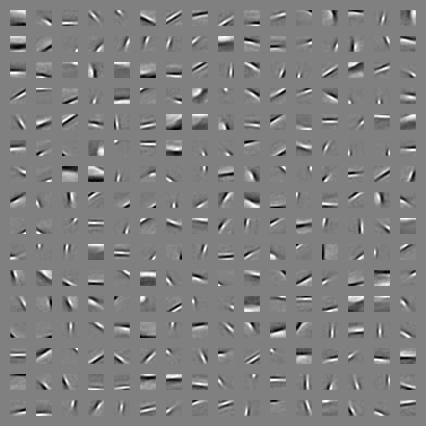

In [60]:
@manipulate for step in slider(ff_rec.steps, value=ff_rec.steps[end], label="step")
    i = searchsortedfirst(ff_rec.steps, step)
    weights = @view ff_rec.arrays[:w][:,:,i]
    rfs = normed(reshape(weights, (N,P,P)), true)
    imgrid(rfs, Ny; pad=10, padval=0.5)
end

Now let's look at the spiking activity:

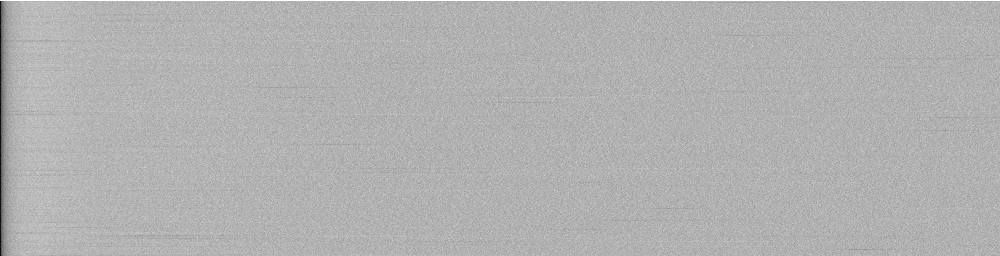

In [71]:
img = raster_spikes(spike_rec, 100_000, 1)
display(colorview(Gray, 1-sqrt.(img/maximum(img))))

And here is a detail view of the spikes emitted for the last few stimuli:

In [62]:
using PyPlot
PyPlot.svg(true);

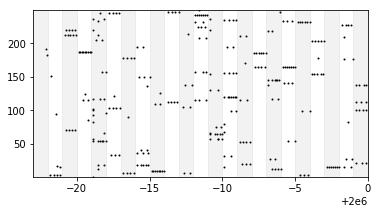

In [65]:
ts = spike_rec.ts[end-300:end]
ids = spike_rec.id[end-300:end]

fig = figure(figsize=(6,3))

s1, s2 = extrema(ts).÷substeps
for x in s1:2:s2
    axvspan(x, x+1, color="gray", alpha=0.1)
end

scatter(ts/substeps, ids, s=1.0, c="k")

autoscale(tight=true)
x1, x2 = xlim()
display(fig)
close(fig)